In [5]:
import numpy as np
import scipy.signal
import math

In [6]:
def compute_air_absorption_coefficients(T, p, rel_hum, freqs):
        """
        Computes air absorption coefficients at a set of nbands equispaced frequencies in the range `[0, fs]`, based
        on the ISO 9613-1 standard. 

        A different formulation can be found in 
        `Keith Attenborough, "Sound Propagation in the Atmosphere", Springer Handbook of Acoustics`, and can be set
        by using T01 = 293.15
        The coefficients depend on the atmsopsheric temperature, pressure and relative humidity.

        Parameters
        ----------
        nbands: int
            Number of frequency bands in which to compute air absorption coefficients, by default 50

        Returns
        -------
        np.ndarray
            1D Array containing nbands air absorption coefficients, computed in dB scale, at the defined 
            set of frequencies

        """

        T0 = 293.15     # Standard room temperature T = 20deg Celsius
        T01 = 273.16    # Triple point isotherm temperature, ISO 9613-1
        T = T + 273.15
        ps0 = 1         # Standard atmospheric pressure in atm

        f = freqs # np.linspace(0, fs, num=nbands)     # Frequencies in which coeffs will be computed
        
        Csat = -6.8346 * math.pow(T01 / T, 1.261) + 4.6151
        rhosat = math.pow(10, Csat)
        H = rhosat * rel_hum * ps0 / p

        frn = (p / ps0) * math.pow(T0 / T, 0.5) * (
                9 + 280 * H * math.exp(-4.17 * (math.pow(T0 / T, 1/3.) - 1)))

        fro = (p / ps0) * (24.0 + 4.04e4 * H * (0.02 + H) / (0.391 + H))

        alpha = f * f * (
            1.84e-11 / ( math.pow(T0 / T, 0.5) * p / ps0 )
            + math.pow(T / T0, -2.5)
            * (
                0.10680 * math.exp(-3352 / T) * frn / (f * f + frn * frn)
                + 0.01278 * math.exp(-2239.1 / T) * fro / (f * f + fro * fro)
                )
            )
        
        return alpha * 20 / np.log(10)

def compute_air_absorption_filter(alpha, freqs, distance, numtaps):
        """
        Computes air absorption filter as a FIR filter with `numtaps` coefficients. The filter depends
        on the distance travelled by the sound wave between the source and the receiver.

        Parameters
        ----------
        distance : float
            Distance travelled by the sound wave, in meters
        numtaps : int
            Number of coefficients of the FIR filter

        Returns
        -------
        np.ndarray
            1D array containing `numtaps` FIR filter coefficients modelling air absorption
        """

        alpha_lin = 10 ** (-alpha * distance / 20)     # Convert coeffs in dB to linear scale
        freqs_norm = freqs / max(freqs)
        filt_coeffs = scipy.signal.firls(numtaps, freqs_norm, alpha_lin)
        
        return filt_coeffs

In [7]:
# Parameters
T = 20
p = 1
rel_hum = 75
fs = 8000
numbands = 50
freqs = np.linspace(0, fs / 2, numbands)
alpha = compute_air_absorption_coefficients(T, p, rel_hum, freqs)

# Distance
d = 2

# Filter
import time
start_time = time.time()
coeffs = compute_air_absorption_filter(alpha, freqs, d, 11)
print(np.shape(coeffs))
print(time.time() - start_time)

(11,)
0.0006000995635986328


In [128]:
## Manual firls implementation

# Frequency grid
w = 2 * np.pi * freqs / (fs/2)

# Filter order
L = 10

# Matrix A
A = np.zeros((len(w),int(L/2 + 1)))
A[:,0] = 1
for i in range(len(w)):
    for j in range(1,int(L/2 + 1)):
        A[i,j] = 2 * math.cos(w[i] * j)

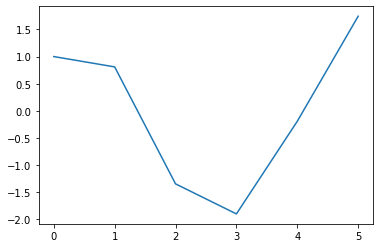

In [129]:
import matplotlib.pyplot as plt
plt.plot(A[40])

In [163]:
alpha_lin = 10 ** (-alpha * d / 20)     # Convert coeffs in dB to linear scale
pseud_A = np.linalg.inv(A.T.dot(A)).dot(A.T)
h_hat = pseud_A.dot(alpha_lin)
# h_hat2 = np.linalg.lstsq(A,alpha_lin, rcond = -1)
h_hat = np.append(np.flip(h_hat[1:]), h_hat)

Norm of difference:  0.0015301583182920108


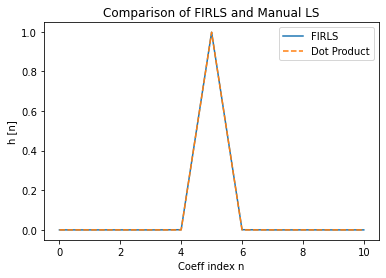

In [169]:
plt.plot(coeffs)
plt.plot(h_hat,'--')
plt.legend(['FIRLS', 'Dot Product'])
plt.title('Comparison of FIRLS and Manual LS')
plt.xlabel('Coeff index n')
plt.ylabel('h [n]')
print('Norm of difference: ', np.linalg.norm(coeffs - h_hat))

In [174]:
# Computational Comparison
import timeit
alpha_lin = 10 ** (-alpha * d / 20)     # Convert coeffs in dB to linear scale

# Dot product
# start_time = time.time()
print('Computational Time Manual LS Method:')
%timeit h_hat = pseud_A.dot(alpha_lin)
print('----------------------------------------------------------------------------\n')
# print(time.time() - start_time)

# Firls
# start_time = time.time()
print('Computational Time FIRLS Method: ')
%timeit h_hat2 = scipy.signal.firls(L+1, freqs, alpha_lin, fs = fs)
# print(time.time() - start_time)


Computational Time Manual LS Method:
281 ns ± 0.812 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
----------------------------------------------------------------------------

Computational Time FIRLS Method: 
84.8 µs ± 155 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
